# Digit Classification with KNN and Naive Bayes

In [53]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined.

In [5]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)


# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


###  Visualization:

Show a 10x10 grid that visualizes 10 examples of each digit.

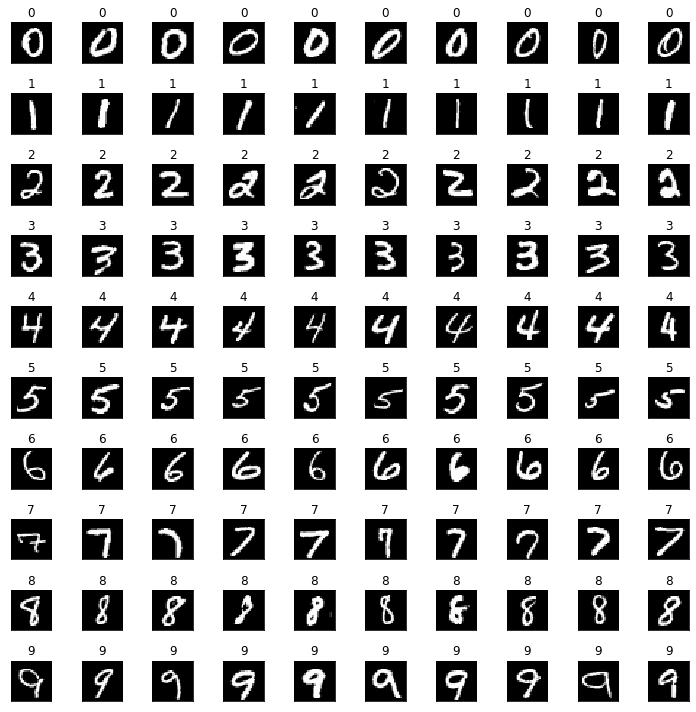

In [6]:
def P1(num_examples=10):
    
    positions = [[] for i in range(10)] # list of list to host position of examples in our data

    count = 0 # counter to break out of loop once we collect enough data
    for index, item in enumerate(Y):

            if len(positions[int(item)]) < num_examples: # append index if we have not collect enough example
                positions[int(item)].append(index)
                count += 1

            if count > num_examples * 10: # break out of loop when enough example is collected
                break
                
    positions = [i for j in positions for i in j] # combine into one list

    
    fig, axes = plt.subplots(10, num_examples, figsize=(num_examples, 10)) # create subplots and resize
    
    for index, ax in enumerate(axes.reshape(-1)): # loop thru each ax
        
        _ = ax.imshow(X[positions[index],:].reshape(28,28), vmin=0, vmax=1, cmap='gray') # plot
        ax.set_title(Y[positions[index]]) # use actual number as title

        ax.get_yaxis().set_visible(False) # remove y axis
        ax.get_xaxis().set_visible(False) # remove x axis

    plt.tight_layout()

P1(10)

### KNN Test:

Produce k-Nearest-Neighbors model with various K. Show the performance of each model. Show precision, recall, and F1 for each label.

* F1 score considers both precision and recall. The most difficult digit is 9 since 9 has the lowest F1 score in all KNN.

In [7]:
def P2(k_values):
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(mini_train_data, mini_train_labels)

        print('classification report with {} neightbors\n'.format(k))
        print(classification_report(test_labels, knn.predict(test_data)))
        print('------------------------------------\n\n')


k_values = [1, 3, 5, 7, 9]
P2(k_values)

classification report with 1 neightbors

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       862
           1       0.86      0.99      0.92      1001
           2       0.96      0.82      0.88       885
           3       0.89      0.86      0.87       949
           4       0.90      0.81      0.85       870
           5       0.84      0.84      0.84       785
           6       0.94      0.95      0.95       906
           7       0.84      0.92      0.88       939
           8       0.89      0.81      0.85       908
           9       0.77      0.82      0.79       895

    accuracy                           0.88      9000
   macro avg       0.88      0.88      0.88      9000
weighted avg       0.88      0.88      0.88      9000

------------------------------------


classification report with 3 neightbors

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       862
           

### KNN Test:

Produce 1-Nearest Neighbor models using training data of various sizes. Show the performance of each model and time needed to train the model.

In [8]:
def P3(train_sizes):
    
    accuracies = []
    for size in train_sizes: # loop thru different sizes
        
        start = time.time() # track the begining time
        knn = KNeighborsClassifier(n_neighbors=1) # set up knn
        knn.fit(train_data[:size], train_labels[:size]) # train knn
        acc = sum(test_labels == knn.predict(test_data))/len(test_labels) # calculate accuracy
        accuracies.append(acc) # append to list
        
        print(('{:,} training examples took {:.2f} seconds to complete\n'
               'accuracy: {:5%}\n').format(size, time.time()-start, acc))
        
    return(accuracies)

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = P3(train_sizes)

100 training examples took 1.04 seconds to complete
accuracy: 69.644444%

200 training examples took 1.88 seconds to complete
accuracy: 78.733333%

400 training examples took 3.66 seconds to complete
accuracy: 82.766667%

800 training examples took 7.35 seconds to complete
accuracy: 87.133333%

1,600 training examples took 15.44 seconds to complete
accuracy: 89.933333%

3,200 training examples took 36.65 seconds to complete
accuracy: 92.588889%

6,400 training examples took 73.70 seconds to complete
accuracy: 94.366667%

12,800 training examples took 148.55 seconds to complete
accuracy: 95.400000%

25,600 training examples took 299.29 seconds to complete
accuracy: 96.355556%



### Create regression to predict KNN's prediction with more datasets:

* it would take too long to actually run the KNN and calculate the accuracy
* linear regression will not be a good use
* trainsformation are used here to turn linear regression into logistic regression to predict the accuracy

Regression is linear. So the Y will continue increase as x increases. This is why the predicted accuracy will exceed 1. We have to apply transformation in order to bond the prediction between 0 and 1. I used logit link function based on https://en.wikipedia.org/wiki/Generalized_linear_model. I also used log of X instead of just X. Both combined improved the result.

Result for normal linear model:

R^2: 0.41
prediction for size of 60,000: 1.24
prediction for size of 120,000: 1.64
prediction for size of 1,000,000: 7.51



Result for log transformed logistic regression:

R^2: 0.99
prediction for size of 60,000: 0.98
prediction for size of 120,000: 0.98
prediction for size of 1,000,000: 0.99


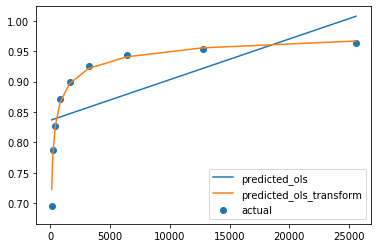

In [9]:
def r2_score(y_actual, y_predicted):
    '''function to calculate r sqaure'''
    y_hat = np.average(y_actual)
    ssr = 0
    sst = 0
    
    for y_act, y_pre in zip(y_actual, y_predicted):
        sst += (y_act - y_hat)**2 # calculate total sum of square
        ssr += (y_act - y_pre)**2 # caluclate sum of sqare residual
    
    return(1 - ssr/sst)
    

def print_output(model, x_tf, y_tf, y_actual, y_predicted):
    '''print the result'''
    print('R^2: {:.2f}'.format(r2_score(y_actual, y_predicted))) # print r square
    
    for i in [60000, 120000, 1000000]: # loop thru these examples to print accuracy predictions
        x_transform = x_tf(i) # transform x using the tranform function
        predicted = y_tf(model.predict(np.array([[x_transform]]))) # predict y and transform it back to probability
        print('prediction for size of {:,}: {:.2f}'.format(i, predicted[0]))
    
    
def P4():
    
    train_sizes_reshape = np.array(train_sizes).reshape(-1, 1) # reshape the train size

    # normal linear regression
    ols = LinearRegression()
    ols.fit(train_sizes_reshape, accuracies)
    predicted = ols.predict(train_sizes_reshape)

    print('Result for normal linear model:\n')
    print_output(ols, lambda x : x, lambda x : x, accuracies, predicted) # there is no transformation, so x = x


    # linear regression with logit transformation, x are logged
    accuracies_transofrm = np.log([i/(1-i) for i in accuracies]) # transform the y for training. This will bond y between 0 to 1
    
    logit_tf = lambda x: np.exp(x)/(1 + np.exp(x)) # function to calculate actual y for based on logit link function. This is the inverse of above function
    log_tf = lambda x: np.log(x) # function to transform x variable

    ols_logit = LinearRegression()
    ols_logit.fit(log_tf(train_sizes_reshape), accuracies_transofrm)
    y = ols_logit.predict(log_tf(train_sizes_reshape)) # prediction of the model
    predicted_logit = logit_tf(y) # calculating the actual y based on transformation

    print('\n\n\nResult for log transformed logistic regression:\n')
    print_output(ols_logit, log_tf, logit_tf, accuracies, predicted_logit)

    
    # creating the plot
    fig, ax = plt.subplots()
    ax.scatter(train_sizes, accuracies, label='actual')
    ax.plot(train_sizes, predicted, label='predicted_ols')
    ax.plot(train_sizes, predicted_logit, label='predicted_ols_transform')
    ax.legend()


P4()

### Error Analysis:

Produce a 1-Nearest Neighbor model and show the confusion matrix.  Show the images of these most often confused digits.

The most confused pair are 4 and 9. Some are actually really hard to get right, but I think we can improve the model to get some of it correct. 

confusion matrix is:
 [[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]] 


the most confused pair: [4, 9]


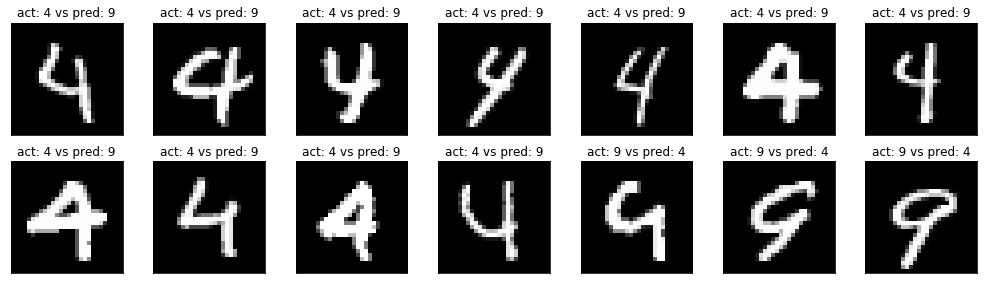

In [13]:
def P5():

    # train the model and produced confusion matrix
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(mini_train_data, mini_train_labels)
    predicted = knn.predict(dev_data)
    cm = confusion_matrix(dev_labels, predicted)
    print('confusion matrix is:\n', cm, '\n\n')
    
    
    # find the most confuse pair (i, j) by ranking error count for (i, j) + (j, i)
    pair = [0, 0] # store the most confused pair
    count = 0 # store the count for most confused pair
    for i in range(cm.shape[0]):
        for j in range(i + 1, cm.shape[1]):
            if cm[i, j] + cm[j, i] >= count: # if error for (i, j) andv (j, i) >= count then reset count and pair index
                count = cm[i, j] + cm[j, i]
                pair = [i, j]
    
    print('the most confused pair: {}'.format(pair))
    
    
    # get the position where our clf gets it wrong for the most confused pair 4, 9
    position = []
    
    for i in range(len(dev_labels)): # loop thru all answers
        if dev_labels[i] != predicted[i]: 
            # add index to list by insert and append, so the 4, 9 will show up before 9, 4 makes graph nicer
            if ([dev_labels[i], predicted[i]] == [str(pair[0]), str(pair[1])]):
                position.insert(0, i) # if pair is 4, 9 insert into the list
            elif ([dev_labels[i], predicted[i]] == [str(pair[1]), str(pair[0])]):
                position.append(i) # if the pair is 9, 4 append into the list

        
    # plot out the most confused pair and where we get it wrong
    fig, axes = plt.subplots(2, 7, figsize=(14, 4))
    
    for i, ax in enumerate(axes.reshape(-1)): # loop thru each ax

        _ = ax.imshow(dev_data[position[i],:].reshape(28,28), vmin=0, vmax=1, cmap='gray') # plot
        ax.set_title('act: {} vs pred: {}'.format(dev_labels[position[i]], predicted[position[i]]))

        ax.get_yaxis().set_visible(False) # remove y axis
        ax.get_xaxis().set_visible(False) # remove x axis
    plt.tight_layout()

P5()

### Gaussian Blur:

A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.

Filters are applied in 3 different ways:
- Filter the training data but not the dev data
- Filter the dev data but not the training data
- Filter both training data and dev data

In [14]:
def gaussian_kernel(sigma=1):
    '''create gaussian kernel'''
    x, y = 3, 3
    x_mean, y_mean = (x - 1)/2, (y - 1)/2
    
    gaussian_kernel = np.zeros((y, x))

    for i in range(gaussian_kernel.shape[0]):
        for j in range(gaussian_kernel.shape[1]):
            # creating the gaussian value based on the distance
            gaussian_kernel[i, j] = np.exp(-1 * ((i-y_mean)**2 + (j-x_mean)**2) / (2 * sigma**2))/(2 * np.pi * sigma**2)
    return(gaussian_kernel)

def gaussian_blur(image, kernel):
    '''perform gaussian blur for the image based on kernel'''
    image_copy = image.copy()

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # calculating the offset to corp out kernel and image for the gaussian blur
            # the following offset also takes care of pixels on edges. (eventhough it does not matter here)
            # for x=0 left offset is 0, right offset is 1. For x=27, left is 1, right is 0. everything else, left is 1, right is 1
            # offset on y is the same idea
            left_offset, right_offset = x - max(x - 1, 0), min(x + 1, image.shape[1] - 1) - x
            up_offset, down_offset = y - max(y - 1, 0), min(y + 1, image.shape[0] - 1) - y
            
            # preparing kernel shape for blur. add additional 1 to y since slicing is exclusive on right side
            revised_kernel = kernel[1-up_offset:1 + 1 +down_offset, 1-left_offset:1 + 1 + right_offset]
            
            # calculating the new blurred pixel
            image_copy[y, x] = np.sum(image[y - up_offset: y + 1 + down_offset,
                                            x - left_offset: x + 1 +right_offset] * (revised_kernel / np.sum(kernel)))

    return(image_copy)

def gaussian_blur_images(data, kernel):
    '''gaussian blur for list of images'''
    data_copy = data.copy()
    for i in range(len(data_copy)):
        data_copy[i] = gaussian_blur(data[i].reshape([28, 28]), kernel).reshape([1, -1])
    return(data_copy)

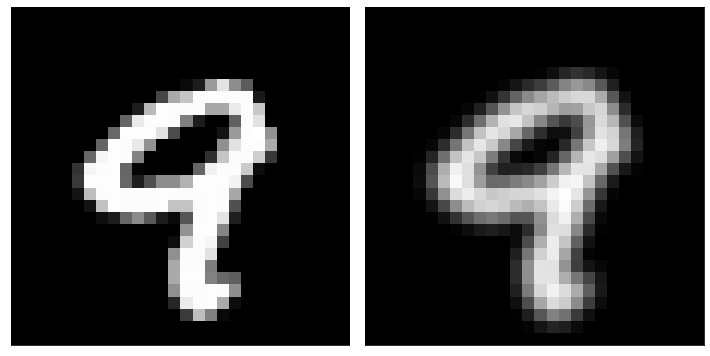

In [15]:
# this box is draft to show gaussian blur example. Plese ignore for grading

image = dev_data[3].reshape(28,28)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

_ = axes[0].imshow(image, vmin=0, vmax=1, cmap='gray') # plot
axes[0].get_yaxis().set_visible(False) # remove y axis
axes[0].get_xaxis().set_visible(False) # remove x axis

image_blurred = gaussian_blur(dev_data[3].reshape([28, 28]), gaussian_kernel(1))
_ = axes[1].imshow(image_blurred, vmin=0, vmax=1, cmap='gray') # plot
axes[1].get_yaxis().set_visible(False) # remove y axis
axes[1].get_xaxis().set_visible(False) # remove x axis

plt.tight_layout()

In [16]:
def accuracy(data, label, test_data, test_labels):
    '''produce accuracy'''
    knn = KNeighborsClassifier(n_neighbors=1) # set up knn
    knn.fit(data, label) # train knn
    acc = sum(test_labels == knn.predict(test_data))/len(test_labels) # calculate accuracy
            
    return(acc)
 

# perform gaussian blur on data
mini_train_data_blur = gaussian_blur_images(mini_train_data, gaussian_kernel())
dev_data_blur = gaussian_blur_images(dev_data, gaussian_kernel())
    
def P6():
    
    acc0 = accuracy(mini_train_data, mini_train_labels, dev_data, dev_labels)
    acc1 = accuracy(mini_train_data_blur, mini_train_labels, dev_data, dev_labels)
    acc2 = accuracy(mini_train_data, mini_train_labels, dev_data_blur, dev_labels)
    acc3 = accuracy(mini_train_data_blur, mini_train_labels, dev_data_blur, dev_labels)


    s = ("accuracy for no filter: {}\n"
         "accuracy for filter on mini train: {}\n"
         "accuracy for filter on dev: {}\n"
         "accuracy for filter on both: {}".format(acc0, acc1, acc2, acc3))
    print(s)
        

P6()

accuracy for no filter: 0.884
accuracy for filter on mini train: 0.906
accuracy for filter on dev: 0.868
accuracy for filter on both: 0.901


### Naive Bayes: `Bernoulli vs Multinomial:

Train a naive bayes model. Compare the performance between bernoulli and mutinomial.

The multinomial did not immprove the performance. I think this reason is because the problem is really a bernoulli problem. A pixel is either on or off. So introducing additional class does not help with the problem.

Text(0.5, 1, 'Multinomial Naive Bayes - Accuracy heatmap')

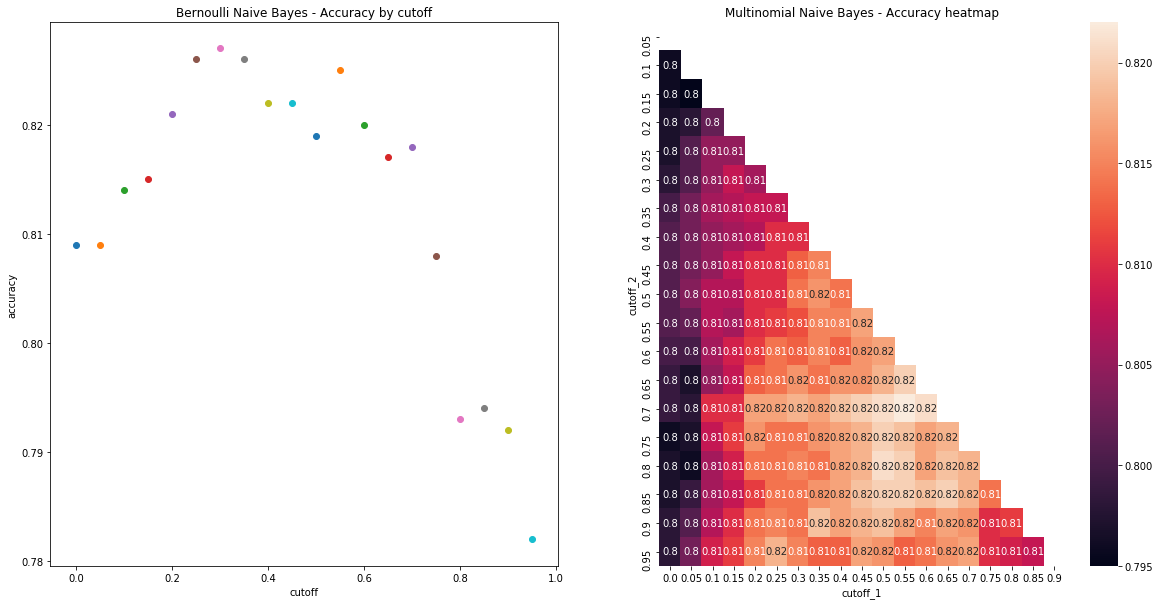

In [126]:
# this box is draft to visualized the different cutoff point. Plese ignore for grading

image = np.zeros([21, 21])
for i in range(image.shape[1]):
    image[:,i] = i * 0.05

fig, axes = plt.subplots(1, 2, figsize=(20, 10))


for cutoff in np.arange(0,1, 0.05):

    NB_binary = BernoulliNB(binarize = cutoff) # x <= cutoff are group vs x > cutoff
    NB_binary.fit(mini_train_data, mini_train_labels)

    accuracy = sum(NB_binary.predict(dev_data) == dev_labels)/len(dev_labels)
    
    axes[0].scatter(cutoff, accuracy)

axes[0].set_xlabel('cutoff')
axes[0].set_ylabel('accuracy')
axes[0].set_title('Bernoulli Naive Bayes - Accuracy by cutoff')
    
    

accuracies = pd.DataFrame(columns=np.arange(0, 0.95, 0.05).round(2), index=np.arange(0.05, 0.99, 0.05).round(2))

for cutoff_1 in np.arange(0, 0.95, 0.05).round(2):
    for cutoff_2 in np.arange(cutoff_1 + 0.05, 0.99, 0.05).round(2):

        mini_train_data_copy = np.where(mini_train_data > cutoff_2, 2, 
                                        np.where(mini_train_data > cutoff_1, 1, 0))

        clf = MultinomialNB()
        clf.fit(mini_train_data_copy, mini_train_labels)
        accuracy = sum(clf.predict(dev_data) == dev_labels)/len(dev_labels)
        accuracies.loc[cutoff_2, cutoff_1] = accuracy
        
        
        
#         print('cutoff {:.2f}, {:.2f}: {:.3f}'.format(cutoff_1, cutoff_2, accuracy))
       
mask = np.zeros_like(accuracies)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(accuracies.fillna(accuracies.stack().mean()), mask=mask, ax=axes[1], annot=True)      
axes[1].set_xlabel('cutoff_1')
axes[1].set_ylabel('cutoff_2')
axes[1].set_title('Multinomial Naive Bayes - Accuracy heatmap')

### Gridsearch:

Search across several values for the LaPlace smoothing parameter (alpha) and cutoff to find its effect on a Bernoulli Naive Bayes model's performance. 

Best alpha: {'alpha': 0.001, 'binarize': 0.5} | Best score: 0.8390000000000001


Text(0.5, 1, 'accuracy by hyperparameters')

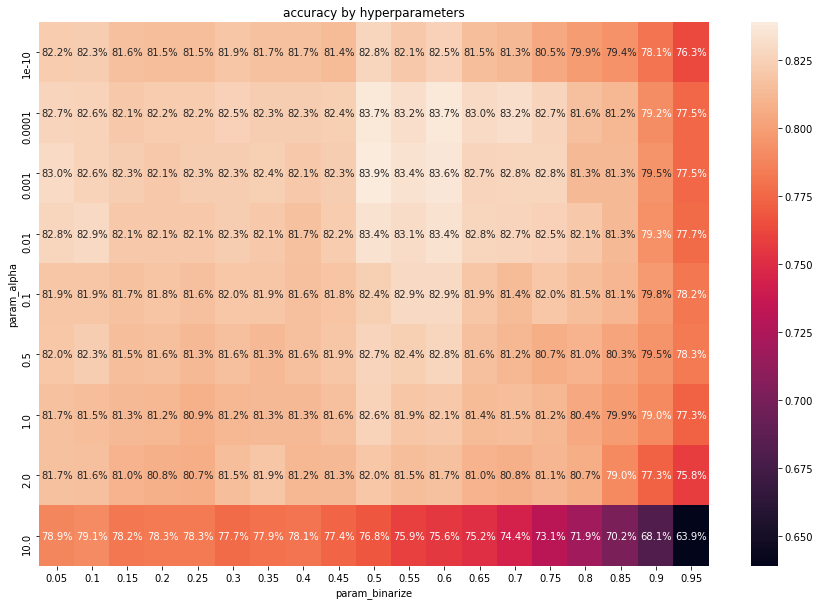

In [145]:
def P8(cutoff, alphas):
    para_grid = {**cutoff, **alphas} # ** will expand dic into keys: values pairs
    
    NB = BernoulliNB()
    clf = GridSearchCV(NB, param_grid=para_grid, scoring='accuracy', cv=5) # set up grid search
    clf.fit(mini_train_data, mini_train_labels)

#     print('accuracy by alphas', clf.cv_results_['mean_test_score'])
    return(clf)


cutoff = {'binarize': np.arange(0.05, 1, 0.05).round(2)}
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}


nb = P8(cutoff, alphas)
print("Best parameters: {} | Best score: {}".format(nb.best_params_, nb.best_score_))



df = pd.pivot_table(pd.DataFrame(nb.cv_results_), values='mean_test_score', columns='param_binarize', index='param_alpha')

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df, annot=True, ax=ax, fmt='.1%')
ax.set_title('accuracy by hyperparameters')

### Gausian Naive Bayes and improvements:

The accuracy for gaussian naive bayes did not work well. The result was poor since the model trying to estimate `variance` (sigma_) for each pixel for every class. For each pixel, it is either on or off. The variance does not need to vary between each class. So I `change the variance to be the same for all pixels and classes. This improved the result dramaticlly!`

In [146]:
def P9():
    
    # standard gaussian naive bayse
    clf = GaussianNB()
    clf.fit(mini_train_data, mini_train_labels)
    
    # getting the theta and sigma
    theta = clf.theta_.copy()
    sigma = clf.sigma_.copy()
    
    accuracy = sum(clf.predict(dev_data) == dev_labels)/len(dev_labels) # calculating accuracy
    print('accuracy: {:.2f}'.format(accuracy))

    
    # applying the simple fix by fixing the sigma across different classes
    for i in range(clf.sigma_.shape[1]):
        clf.sigma_[:, i] = np.mean(clf.sigma_) # fixing variance for all features. It works here because all features have same measurement. They all represents pixels.
#         clf.sigma_[:, i] = np.mean(clf.sigma_[:, i]) # if features have different mesurement, this might be a better way.
    
    accuracy = sum(clf.predict(dev_data) == dev_labels)/len(dev_labels)
    print('accuracy with simple fix: {:.2}'.format(accuracy))
    


P9()

accuracy: 0.59
accuracy with simple fix: 0.8


### Naive Bayes is a generative mode. Use the model to generate digit images:

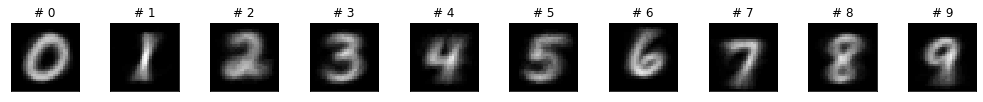

In [152]:
def P10():
    
    #train the model
    clf = BernoulliNB(binarize=0.5, alpha=0.001)
    clf.fit(mini_train_data, mini_train_labels)

    feature_prob = np.exp(clf.feature_log_prob_) # getting the probability

    num_examples = 20
    # set up plots
    fig, axes = plt.subplots(1, 10, figsize=(14, 1/10*14))

    cutoff_array = np.arange(0, 1, 1/num_examples)
    
        
    for index, j in enumerate(axes):
        # diaplay probability based on the cutoff
        j.imshow(feature_prob[index].reshape([28,28]),  vmin=0, vmax=1, cmap='gray')

        j.set_title('# {}'.format(index)) # for title, show number and cutoff point
        j.get_xaxis().set_visible(False) # remove y axis
        j.get_yaxis().set_visible(False) # remove y axis

    plt.tight_layout()

P10()

### Test if Naive Bayes is a `strongly calibrated classifier`.

A strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior probability of the predicted class is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior probability and accuracy.  

Overall, we can see a clear relationship between the predicted probability and predicted probability and actual accuracy. However, it is not 1 to 1 relationship. So the model is weakly calibrated. This is likely due to the assumption of independece which is not true here. So the classifer is often over confident at it's accuracy.

In [175]:
def P11(buckets, correct, total):
    
    # create model and getting predicted label and probability
    clf = BernoulliNB(binarize=0.5, alpha=0.001)
    clf.fit(mini_train_data, mini_train_labels)
    predicted = clf.predict(dev_data)
    predicted_prob = clf.predict_proba(dev_data)

    # getting prediction's probability
    winning_prob = []    
    for num, prob in zip(predicted, predicted_prob):
        winning_prob.append(prob[int(num)])

        
    # for each prediction placing them into the correct bucket
    for index in range(len(predicted)):
        prob = winning_prob[index]
        for i in range(len(buckets) - 1):
            
             # based on the condition and place the prediction into correct bucket
            if prob > buckets[i] and prob <= buckets[i+1]:
                total[i] += 1
                if predicted[index] == dev_labels[index]: correct[i] += 1
                break
                
            


buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in range(len(buckets)-1)]
total = [0 for i in  range(len(buckets)-1)]

P11(buckets, correct, total)

for i in range(len(buckets)-1):
    accuracy = correct[i]/total[i]
    print('p(pred) is {:>17.12%} to {:>17.12%}    total = {:<3}   accuracy = {:.2%}'.format(buckets[i], buckets[i+1], total[i], accuracy))

p(pred) is  50.000000000000% to  90.000000000000%    total = 36    accuracy = 38.89%
p(pred) is  90.000000000000% to  99.900000000000%    total = 90    accuracy = 44.44%
p(pred) is  99.900000000000% to  99.999000000000%    total = 69    accuracy = 56.52%
p(pred) is  99.999000000000% to  99.999990000000%    total = 67    accuracy = 67.16%
p(pred) is  99.999990000000% to  99.999999900000%    total = 50    accuracy = 82.00%
p(pred) is  99.999999900000% to  99.999999999000%    total = 72    accuracy = 90.28%
p(pred) is  99.999999999000% to  99.999999999990%    total = 66    accuracy = 89.39%
p(pred) is  99.999999999990% to 100.000000000000%    total = 550   accuracy = 95.45%
